In [12]:
import pickle

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

from deepfly.GUI.CameraNetwork import CameraNetwork
from deepfly.GUI.Config import config_fly as config
from deepfly.GUI.util.os_util import *
from deepfly.GUI.util.plot_util import normalize_pose_3d
from deepfly.GUI.util.signal_util import *

%load_ext autoreload
%autoreload 2
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
image_folder = '../data/test/'
image_folder = os.path.abspath(image_folder)
output_folder = '../images/'

calib = read_calib(image_folder)
skeleton = config["skeleton"]

cid2cidread, cidread2cid = read_camera_order(image_folder)
camNet = CameraNetwork(image_folder=image_folder, num_images=None, cam_id_list=np.arange(config["num_cameras"]), calibration=calib, cid2cidread=cid2cidread)

# loading final results
d = pickle.load(open(glob.glob(os.path.join(image_folder, 'pose_result*.pkl'))[0], 'rb'))
for cam in camNet:
    cam.points2d = d["points2d"][cam.cam_id, :]
# calculating 3d points
camNet.triangulate()
pts3d = camNet.points3d_m
pts3d_filter = filter_batch(pts3d)

Loading predictions ['/home/user/Desktop/DeepFly3D/data/test/preds_-home-user-Desktop-DeepFly3D-data-test.pkl']
Loading heatmaps ['/home/user/Desktop/DeepFly3D/data/test/heatmap_-home-user-Desktop-DeepFly3D-data-test.pkl']
Heatmap shape: (8, 15, 19, 64, 128)


# 2D Pose Visualization

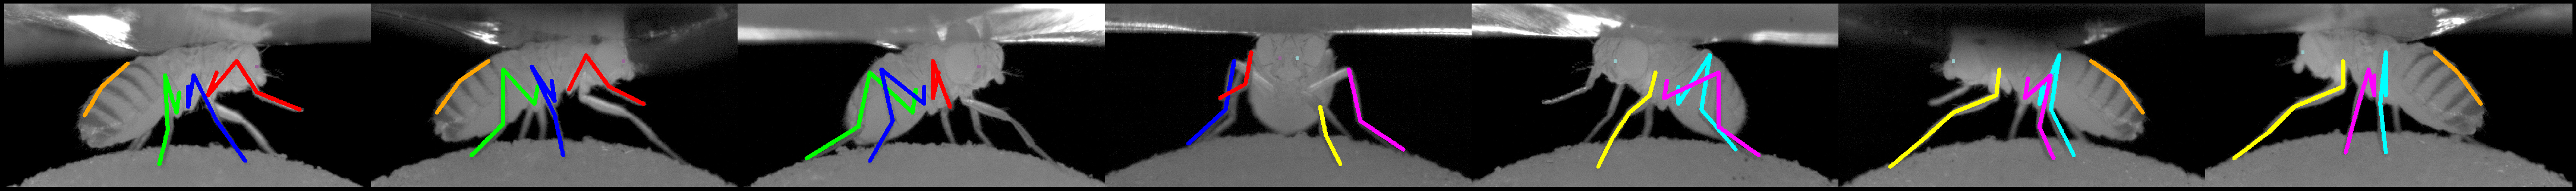

In [8]:
fig, ax_list = plt.subplots(1, config["num_cameras"],figsize=(60,60))
points2d_list = list()
for cam in camNet:
    points2d_list.append(cam.points2d)
for idx in range(len(ax_list)):
    ax_list[idx].axis('off')
    ax_list[idx] = ax_list[idx].imshow(np.zeros((480,960,3)))

img_id = 0
for cam_id, ax in zip(range(config["num_cameras"]), ax_list):
    thickness = [10]*skeleton.num_limbs
    colors_tmp = skeleton.colors.copy()
    for l in range(skeleton.num_limbs):
        if not skeleton.camera_see_limb(camNet[cam_id].cam_id, l):
            thickness[l] = 5
            colors_tmp[l] = (125,125,125)           
    pts = camNet[cam_id].points2d[img_id, :].copy()

    zorder = skeleton.get_zorder(cam_id)
    #ax.imshow(camNet[cam_id].plot_2d(img_id=img_id, pts=pts, flip_points=False, colors=colors_tmp, thickness=thickness, zorder=zorder))
    ax.set_data(camNet[cam_id].plot_2d(img_id=img_id, pts=pts, colors=colors_tmp, thickness=thickness, zorder=zorder))

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())


#plt.savefig(os.path.join(output_folder,f'pose2d_{img_id}.png'), bbox_inches = 'tight',
#    pad_inches = 0)


fly


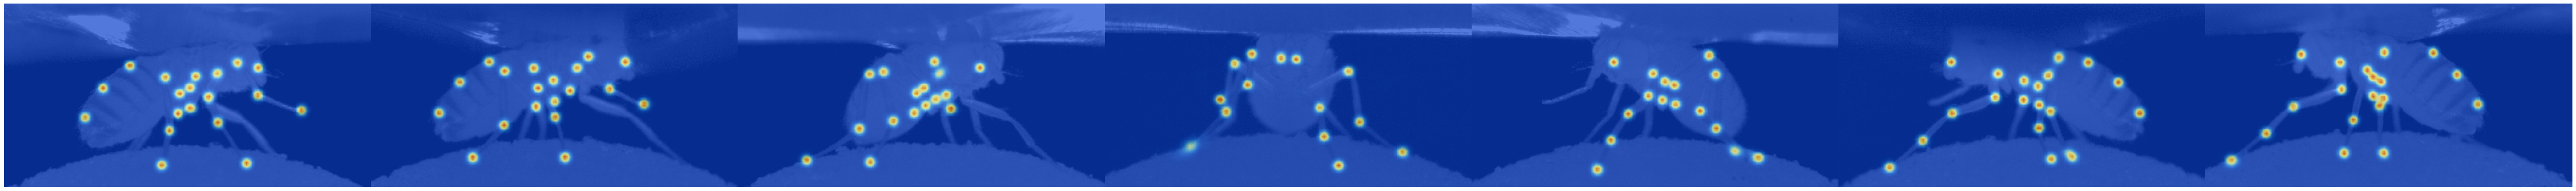

In [9]:
print(config["name"])
%matplotlib inline
img_id = 0
n_cameras = 7
fig, ax_list = plt.subplots(1,n_cameras,figsize=(60,60))
for cam_id, ax in zip(range(n_cameras), ax_list):
    draw_joints = [j for j in range(skeleton.num_joints) if skeleton.camera_see_joint(cam_id, j)]
    pt = camNet.points3d_m[img_id, :]
    img = camNet[cam_id].get_image(img_id)
    for j in range(skeleton.num_joints):
        if skeleton.is_tracked_point(j, skeleton.Tracked.STRIPE) and skeleton.is_joint_visible_left(j):
            pt[j] = (pt[j] + pt[j+(skeleton.num_joints // 2)]) / 2
            pt[j + skeleton.num_joints // 2] = pt[j]
    pts2d = camNet[cam_id].project(pt)

    thickness = [5]*skeleton.num_limbs
    colors_tmp = skeleton.colors.copy()
    for l in range(skeleton.num_limbs):
        if not skeleton.camera_see_limb(camNet[cam_id].cam_id, l):
            thickness[l] = 2
            colors_tmp[l] = (125,125,125)
        
    zorder = skeleton.get_zorder(cam_id)
    #ax.imshow(camNet[cam_id].plot_2d(img=np.ones((480,960,3), dtype=np.uint8), img_id=img_id, pts=pts2d, flip_points=False, colors=colors_tmp, thickness=thickness, draw_joints=draw_joints, zorder=zorder))
    ax.imshow(camNet[cam_id].plot_heatmap(img_id, img=img, flip_heatmap=False, draw_joints=draw_joints))
    ax.axis('off')

plt.gca().set_axis_off()
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

plt.savefig(os.path.join(output_folder, f"heatmap_{img_id}.png"), bbox_inches = 'tight',
    pad_inches = 0)

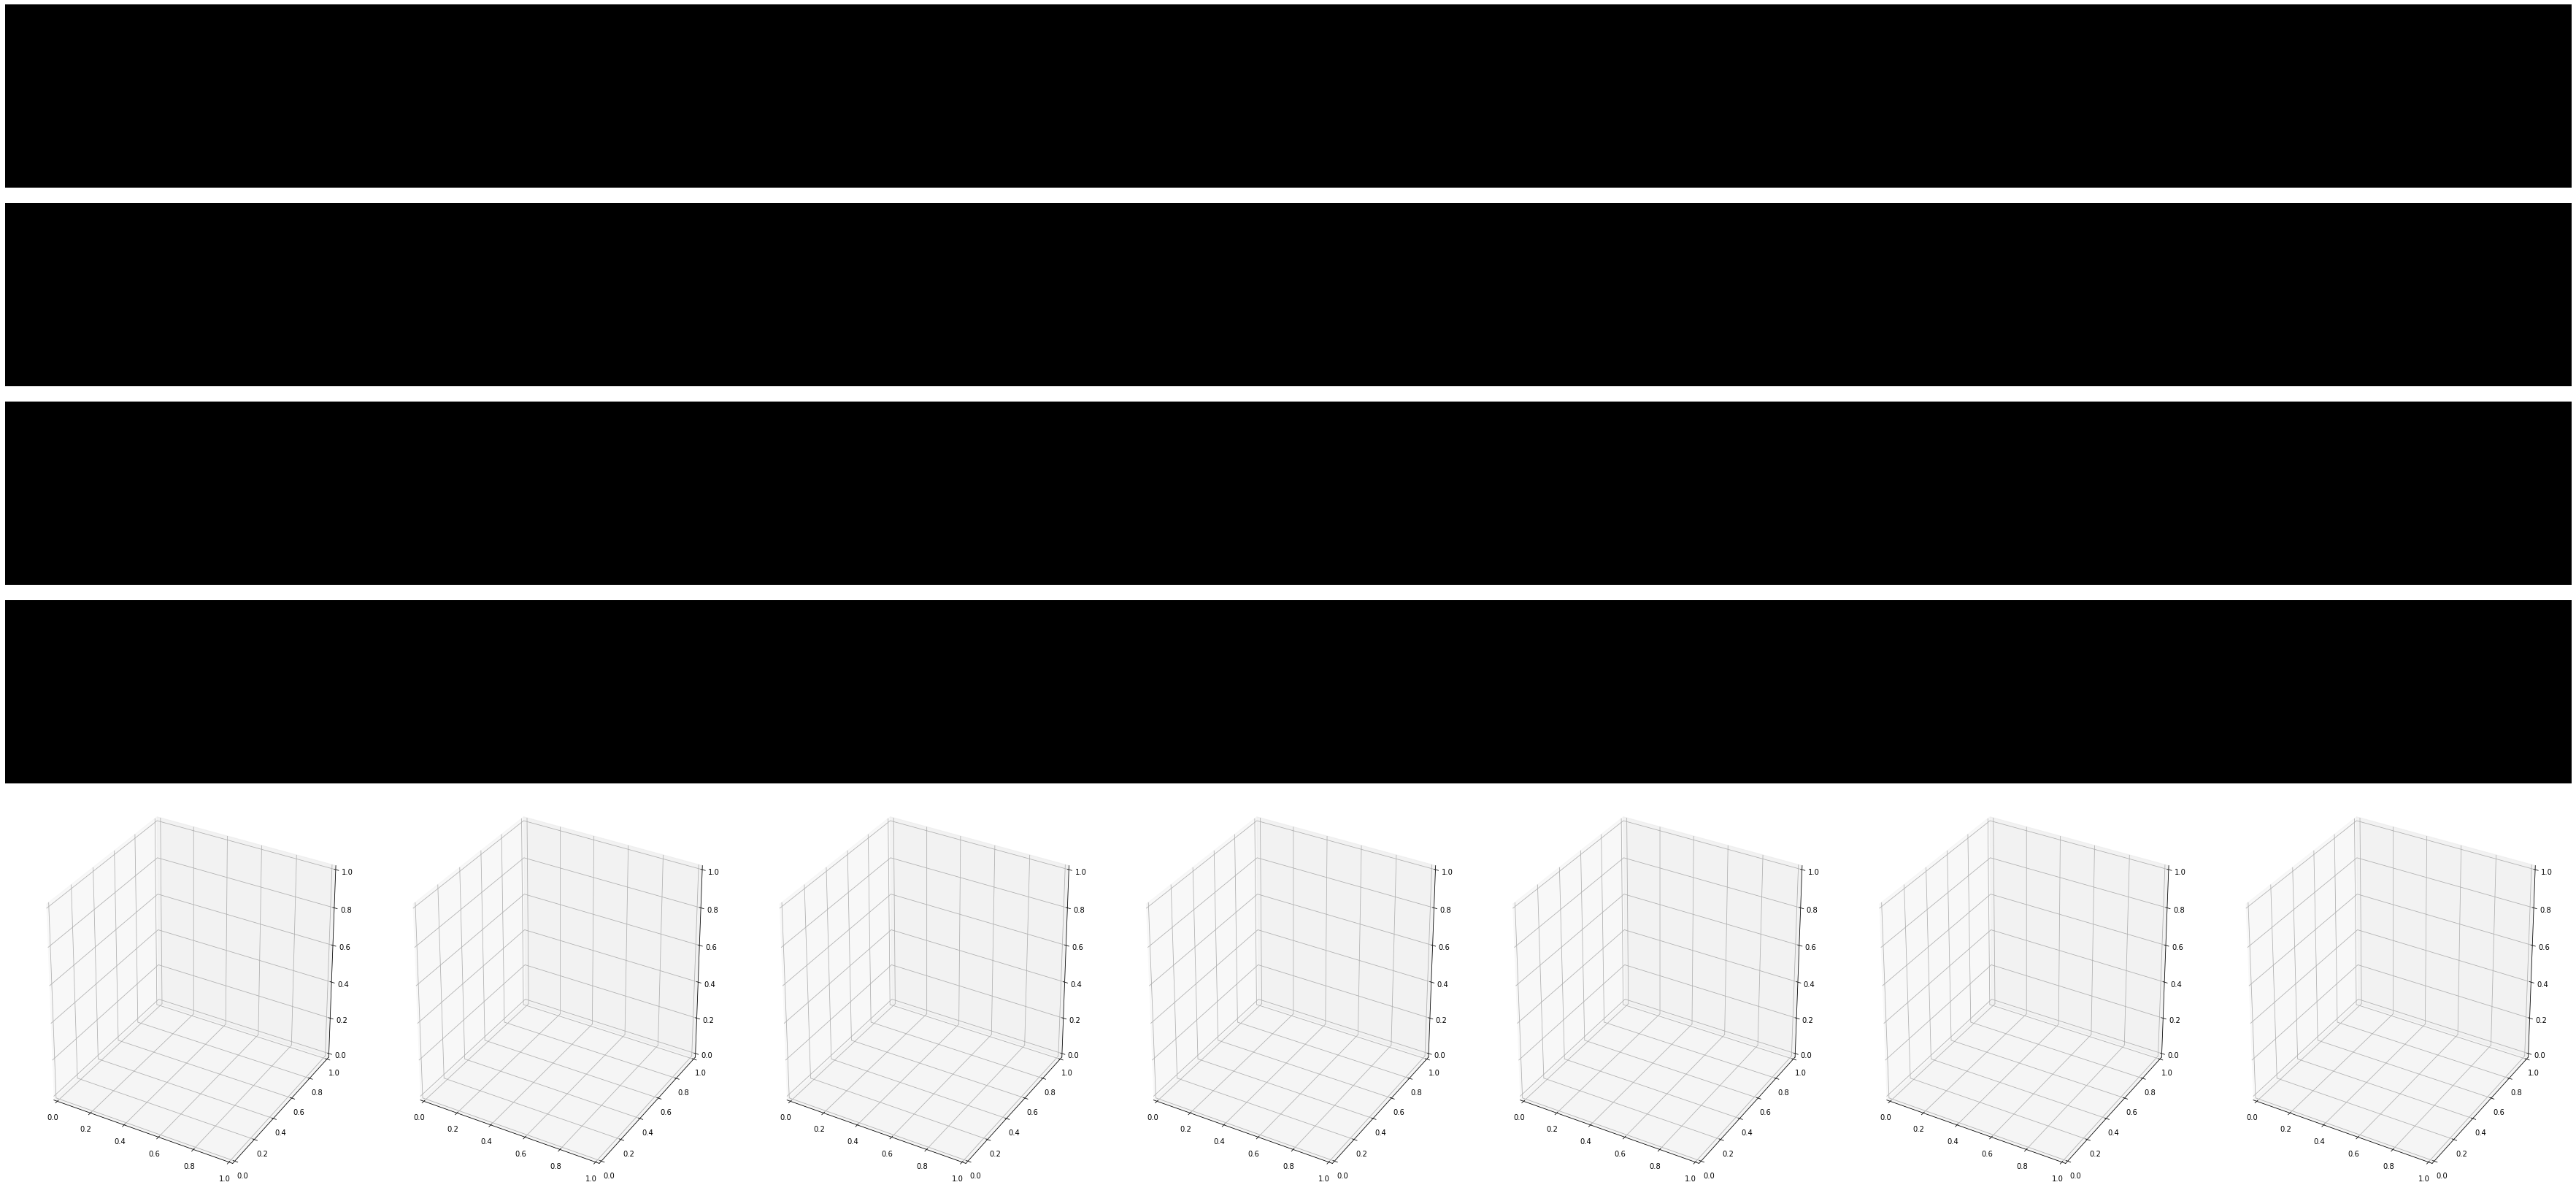

In [14]:
# preparing the plot axis
plt.style.use('default')
%matplotlib inline
pts3d_filter = pts3d.copy()

%matplotlib inline


num_rows, num_cols = 6, 7
fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

plt_list = []

pts_t = pts3d_filter.copy()
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 

pts_t = normalize_pose_3d(pts_t, normalize_median=True)

for i in range(num_rows*num_cols):
    r = int(i / num_cols)
    c = i % num_cols
    if r==4:
        ax1 = plt.subplot(gs1[r:, c] , projection='3d')
    elif r<4:
        ax1 = plt.subplot(gs1[r,c])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_aspect('equal')
        plt.axis('off')
    if r==4:
        plt_list.append(ax1)
    elif r<4:
        plt_list.append(ax1.imshow(np.zeros((480,960,3), dtype=np.uint8)))

0


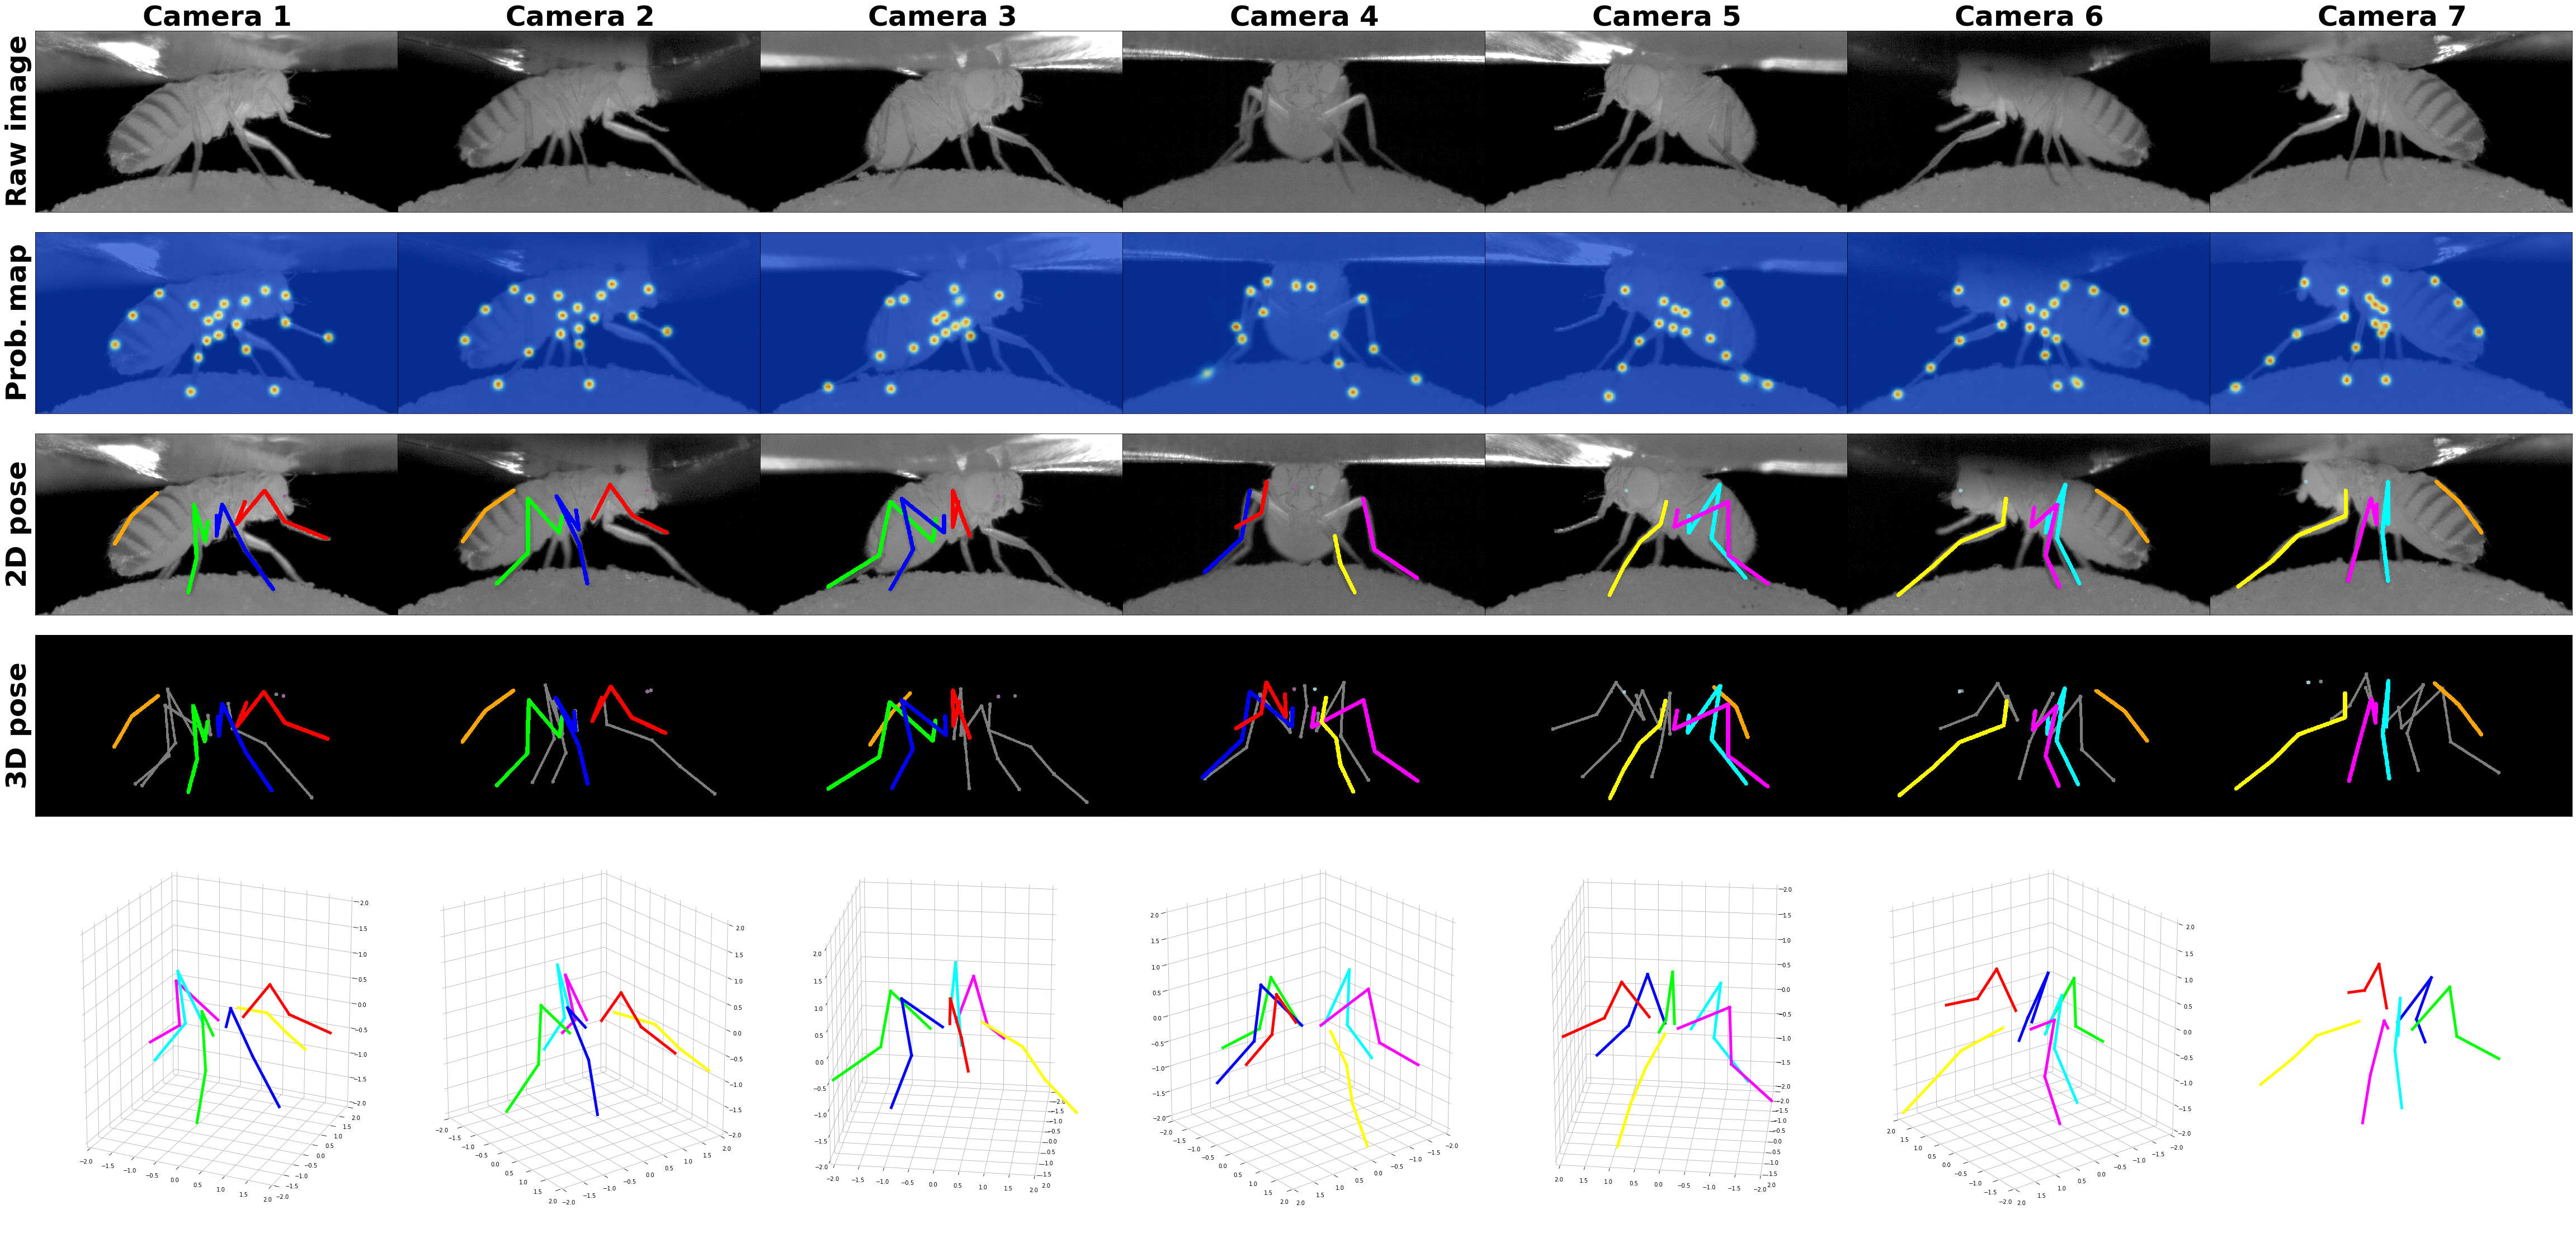

In [27]:
plt.style.use('default')
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from deepfly.GUI.util.plot_util import plot_drosophila_3d
from deepfly.GUI.util.plot_util import normalize_pose_3d

fontsize = 50
num_rows, num_cols = 6, 7
fig = plt.figure(figsize=(num_cols*9,num_rows*5))

gs1 = gridspec.GridSpec(num_rows, num_cols)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

plt_list = []

pts_t = pts3d_filter.copy()
tmp = pts_t[:,:,1].copy()
pts_t[:,:,1] = pts_t[:,:,2].copy()
pts_t[:,:,2] = tmp
pts_t[:,:,2] *=-1 
pts_t[:,:,1] *=-1 

pts_t = normalize_pose_3d(pts_t, normalize_median=True)
title_list = ["Camera\ {}".format(i) for i in range(1,8)]
ylabel_list = ["Raw\ image", "Prob. map", "2D\ pose", r"Projected 3D pose", "3D\ pose"]
for i in range(num_rows*num_cols):
    r = int(i / num_cols)
    c = i % num_cols
    if r==4:
        ax1 = plt.subplot(gs1[r:, c] , projection='3d')
        #ax1.set_xticks([])
        #ax1.set_yticks([])
        #ax1.set_zticks([])
        ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    elif r<4:
        ax1 = plt.subplot(gs1[r,c])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.set_aspect('equal')
        #plt.axis('off')
        
    if r==0:
        ax1.set_title( r"$\bf{" + title_list[c] + "}$", fontsize=fontsize, fontname="Times New Roman Bold")
    if c==0 and r==3: 
        ax1.set_ylabel(r"$\bf{3D\ pose}$", fontsize=fontsize)
    if c==0 and r!=3 and r!=4 and r!=5:
        ax1.set_ylabel(r"$\bf{" + ylabel_list[r] + "}$", fontsize=fontsize)
    if c==0 and r==4:
        pass
        
    if r==4:
        plt_list.append(ax1)
    elif r<4:
        plt_list.append(ax1.imshow(np.zeros((480,960,3), dtype=np.uint8)))
        if c==num_cols-1 and r==0:
            pass

img_id_list = np.arange(0, 1)
for img_id in img_id_list:
    if img_id%50==0:
        print(img_id)
    for r in range(num_rows):
        for c in range(num_cols):
            img = camNet[c].get_image(img_id)
            zorder = skeleton.get_zorder(c)
            draw_joints = [j for j in range(skeleton.num_joints) if skeleton.camera_see_joint(c, j)]
            i = r*num_cols + c
            if r == 0: # raw
                plt_list[i].set_data(img)
            elif r==1: # heatmap
                plt_list[i].set_data(camNet[c].plot_heatmap(img_id, img=img, flip_heatmap=False, draw_joints=draw_joints))
            elif r==2: # 2d pose
                draw_limbs = None
                plt_list[i].set_data(camNet[c].plot_2d(img_id, img=img, flip_points=False, draw_limbs=draw_limbs, zorder=zorder, thickness=[10]*skeleton.num_limbs))
            elif r==3: # projection of 3d pose
                draw_joints = range(skeleton.num_joints)
                pt = pts3d_filter[img_id,:,:]
                for j in range(skeleton.num_joints):
                    if skeleton.is_tracked_point(j, skeleton.Tracked.STRIPE) and skeleton.is_joint_visible_left(j):
                        pt[j] = (pt[j] + pt[j+(skeleton.num_joints // 2)]) / 2
                        pt[j + skeleton.num_joints // 2] = pt[j]
                pts2d = camNet[c].project(pt)
                
                thickness = [10]*skeleton.num_limbs
                colors_tmp = skeleton.colors.copy()
                for l in range(skeleton.num_limbs):
                    if not skeleton.camera_see_limb(camNet[c].cam_id, l):
                        thickness[l] = 5
                        colors_tmp[l] = (125,125,125)
                plt_list[i].set_data(camNet[c].plot_2d(img=np.ones((480,960,3), dtype=np.uint8), img_id=img_id, pts=pts2d, flip_points=False, colors=colors_tmp, thickness=thickness, draw_joints=draw_joints, zorder=zorder))
            elif r==4: # 3d pose
                ax_3d = plt_list[i]
                points3d = pts_t[img_id,:,:]
                
                ang = -90 - (camNet[c].rvec[1]*57.2)
                period = 180.0 # frames
                extend = -20
                # rotate cameras 
                ang_move = np.sin(2*np.pi*((img_id)/period))*extend
                ang += ang_move
                
                ax_3d.elev = 20
                draw_joints = [j for j in range(skeleton.num_joints) if (skeleton.is_tracked_point(j, skeleton.Tracked.COXA_FEMUR) or skeleton.is_tracked_point(j, skeleton.Tracked.FEMUR_TIBIA) or skeleton.is_tracked_point(j, skeleton.Tracked.TIBIA_TARSUS) or skeleton.is_tracked_point(j, skeleton.Tracked.TARSUS_TIP))]
                
                colors_tmp = skeleton.colors.copy()
                thickness = [config["line_thickness"]]*skeleton.num_limbs
                                        
                xlim = [np.min(pts_t[:,:,0]), np.max(pts_t[:,:,0])]
                ylim = [np.min(pts_t[:,:,1]), np.max(pts_t[:,:,1])]
                zlim = [np.min(pts_t[:,:,2]), np.max(pts_t[:,:,2])]
                plot_drosophila_3d(ax_3d=ax_3d, points3d=points3d, cam_id=c, ang=ang, draw_joints=draw_joints, zorder=zorder, colors=colors_tmp, thickness=thickness, lim=2)
    #plt.show()
    plt.gca().set_axis_off()
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                hspace = 0, wspace = 0)
    #plt.margins(0.9,0.1,0.1)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    
    plt.savefig(os.path.join(output_folder, f'row5_{img_id}.png'), bbox_inches = 'tight',
       pad_inches = 0)
    for c in range(num_cols):
        if num_rows >= 4:
            r = 4
            i = r*num_cols + c
            ax_3d = plt_list[i]
            #ax_3d.cla()    